In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Step 1: Problem Formulation & Target Variable Analysis

**Objective:** Predict whether a loan will be paid back (`loan_paid_back` = 1) or not (default, `loan_paid_back` = 0).

We treat `loan_paid_back == 0` as a default. This analysis inspects the target distribution, missing values, and per-group default rates to inform preprocessing and modeling choices.

In [30]:
df = pd.read_csv('loan_data.csv')
print('Dataset shape:', df.shape)
display(df.head())
print('\nInfo:')
display(df.info())
print('\nSummary (including categorical):')
display(df.describe(include='all').T)
if 'loan_paid_back' not in df.columns:
    print('Expected target column "loan_paid_back" not found in dataset')

print('\nTarget counts:')
display(df['loan_paid_back'].value_counts(dropna=False))
print('\nTarget proportion (paid back == 1):', df['loan_paid_back'].mean())
df['is_default'] = (df['loan_paid_back'] == 0).astype(int)


Dataset shape: (268114, 13)


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268114 entries, 0 to 268113
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    268114 non-null  int64  
 1   annual_income         268114 non-null  float64
 2   debt_to_income_ratio  268114 non-null  float64
 3   credit_score          268114 non-null  int64  
 4   loan_amount           268114 non-null  float64
 5   interest_rate         268114 non-null  float64
 6   gender                268114 non-null  object 
 7   marital_status        268114 non-null  object 
 8   education_level       268114 non-null  object 
 9   employment_status     268114 non-null  object 
 10  loan_purpose          268114 non-null  object 
 11  grade_subgrade        268114 non-null  object 
 12  loan_paid_back        268114 non-null  int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 26.6+ MB


None


Summary (including categorical):


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,268114.0,NaN,NaN,NaN,134056.5,77397.989374,0.0,67028.25,134056.5,201084.75,268113.0
annual_income,268114.0,NaN,NaN,NaN,48203.659176,26735.817913,6002.43,27897.19,46552.49,60981.32,393381.74
debt_to_income_ratio,268114.0,NaN,NaN,NaN,0.120764,0.06875,0.011,0.072,0.096,0.156,0.577
credit_score,268114.0,NaN,NaN,NaN,680.831732,55.404553,395.0,646.0,682.0,719.0,849.0
loan_amount,268114.0,NaN,NaN,NaN,15028.884002,6932.802588,500.91,10281.41,15011.15,18872.21,48959.95
interest_rate,268114.0,NaN,NaN,NaN,12.357615,2.008781,3.66,10.99,12.37,13.68,20.84
gender,268114,3,Female,138314,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital_status,268114,4,Single,130461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education_level,268114,5,Bachelor's,126443,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_status,268114,5,Employed,203430,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Target counts:


loan_paid_back
1    214068
0     54046
Name: count, dtype: int64


Target proportion (paid back == 1): 0.7984215669454038


In [31]:
# step 2 finding missing values
missing = df.isna().sum().sort_values(ascending=False)
print('\nMissing values (top 20):')
display(missing[missing>0].head(20))
cats = [c for c in ['education_level','loan_purpose','grade','subgrade'] if c in df.columns]
for col in cats:
    grp = df.groupby(col)['is_default'].agg(['mean','count']).rename(columns={'mean':'default_rate','count':'n'}).sort_values('n',ascending=False)
    print(f'\nDefault rates by {col}: (top 10 by count)')
    display(grp.head(10))
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ['id','loan_paid_back','is_default']]
if numeric_cols:
    print('\nNumeric medians by loan_paid_back:')
    display(df.groupby('loan_paid_back')[numeric_cols].median().T)



Missing values (top 20):


Series([], dtype: int64)


Default rates by education_level: (top 10 by count)


,default_rate,n
education_level,,
Bachelor's,0.211534,126443
High School,0.190906,82559
Master's,0.197456,42060
Other,0.198537,12028
PhD,0.168193,5024



Default rates by loan_purpose: (top 10 by count)


,default_rate,n
loan_purpose,,
Debt consolidation,0.203123,146739
Other,0.201612,28783
Car,0.200810,26179
Home,0.174334,19824
Education,0.221288,16526
Business,0.183992,15930
Medical,0.224066,10363
Vacation,0.215915,3770



Numeric medians by loan_paid_back:


loan_paid_back,0,1
annual_income,45922.940,46667.560
debt_to_income_ratio,0.165,0.092
credit_score,656.000,688.000
loan_amount,15111.935,14982.510
interest_rate,12.890,12.250


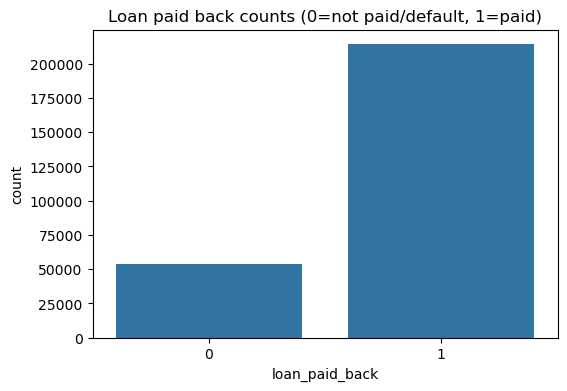

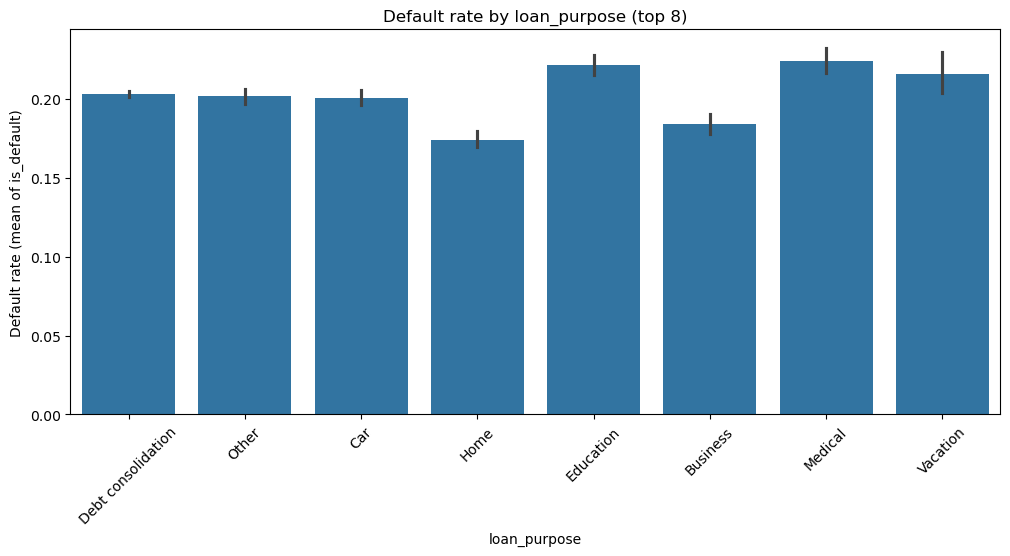

In [32]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='loan_paid_back')
plt.title('Loan paid back counts (0=not paid/default, 1=paid)')
plt.show()
if 'loan_purpose' in df.columns:
    purpose_counts = df['loan_purpose'].value_counts().head(20)
    top_purposes = purpose_counts.index.tolist()[:8]
    subset = df[df['loan_purpose'].isin(top_purposes)]
    plt.figure(figsize=(12,5))
    sns.barplot(data=subset, x='loan_purpose', y='is_default', order=top_purposes)
    plt.ylabel('Default rate (mean of is_default)')
    plt.title('Default rate by loan_purpose (top 8)')
    plt.xticks(rotation=45)
    plt.show()

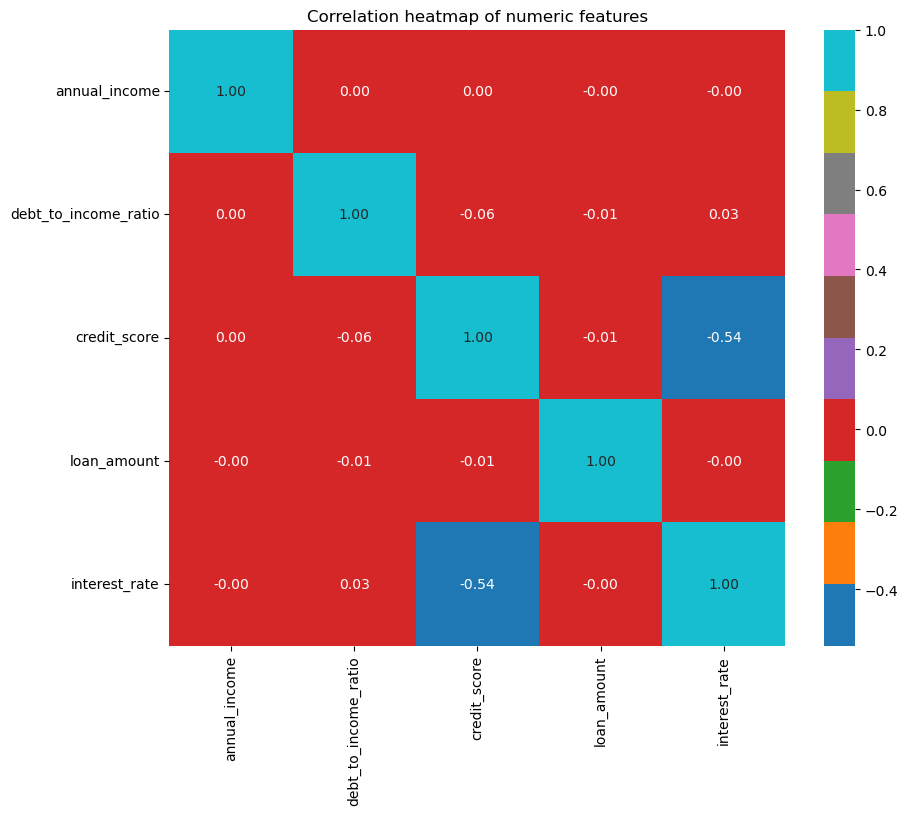

In [33]:
# correlation heatmap
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ['id','loan_paid_back','is_default']]
if len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='tab10', square=True)
    plt.title('Correlation heatmap of numeric features')
    plt.show()

In [34]:
numeric_features = ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
numeric_features = [c for c in numeric_features if c in df.columns]
categorical_features = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade', 'subgrade']
categorical_features = [c for c in categorical_features if c in df.columns]
print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)

Numeric features: ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
Categorical features: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose']


In [35]:
# Prepare X (features) and y (target)
X = df[numeric_features + categorical_features].copy()
y = df['loan_paid_back'].astype(int)

print('\nX shape:', X.shape)
print('y value counts:', y.value_counts().to_dict())
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.37, random_state=30, stratify=y
)
print('\nTrain set: X_train shape', X_train.shape, 'y_train mean:', y_train.mean())
print('Test set: X_test shape', X_test.shape, 'y_test mean:', y_test.mean())


X shape: (268114, 10)
y value counts: {1: 214068, 0: 54046}

Train set: X_train shape (168911, 10) y_train mean: 0.7984204699516313
Test set: X_test shape (99203, 10) y_test mean: 0.798423434775158


In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [37]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

In [38]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

In [39]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print('\nAfter preprocessing:')
print('X_train_processed shape:', X_train_processed.shape)
print('X_test_processed shape:', X_test_processed.shape)



After preprocessing:
X_train_processed shape: (168911, 30)
X_test_processed shape: (99203, 30)


In [40]:

feature_names = []
feature_names.extend(numeric_features)
cat_encoder = preprocessor.named_transformers_['cat']['onehot']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
feature_names.extend(cat_feature_names)

print(f'\nTotal features after preprocessing: {len(feature_names)}')
print('Sample feature names (first 10):', feature_names[:10])


Total features after preprocessing: 30
Sample feature names (first 10): ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'gender_Female', 'gender_Male', 'gender_Other', 'marital_status_Divorced', 'marital_status_Married']


In [41]:
#step 3: Model Development and Tuning
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

Starting RandomizedSearchCV for hyperparameter tuning...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Applications/anaconda/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [10:43:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Applications/anaconda/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [10:43:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Applications/anaconda/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [10:43:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Applications/anaconda/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [10:43:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters:


Best hyperparameters found:
{'classifier__subsample': 1.0, 'classifier__n_estimators': 300, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 0.85}
Best cross-validation AUC: 0.9166719837993014

ROC AUC on test set: 0.9169

ROC AUC on test set: 0.9169


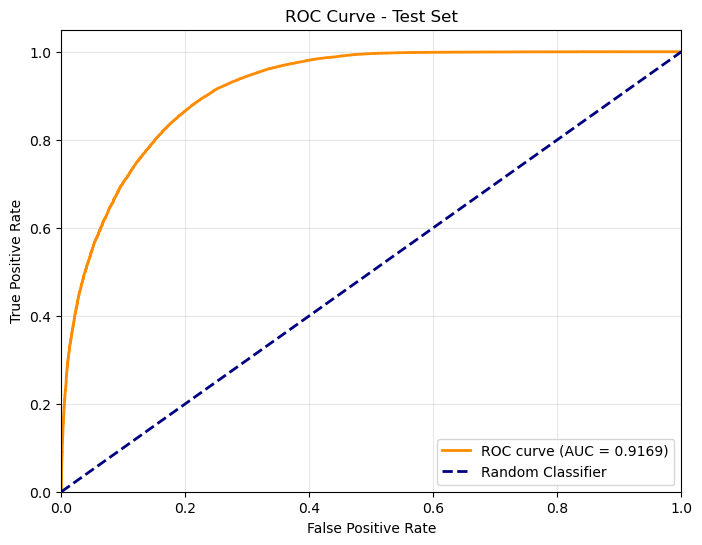


Top 15 most important features:


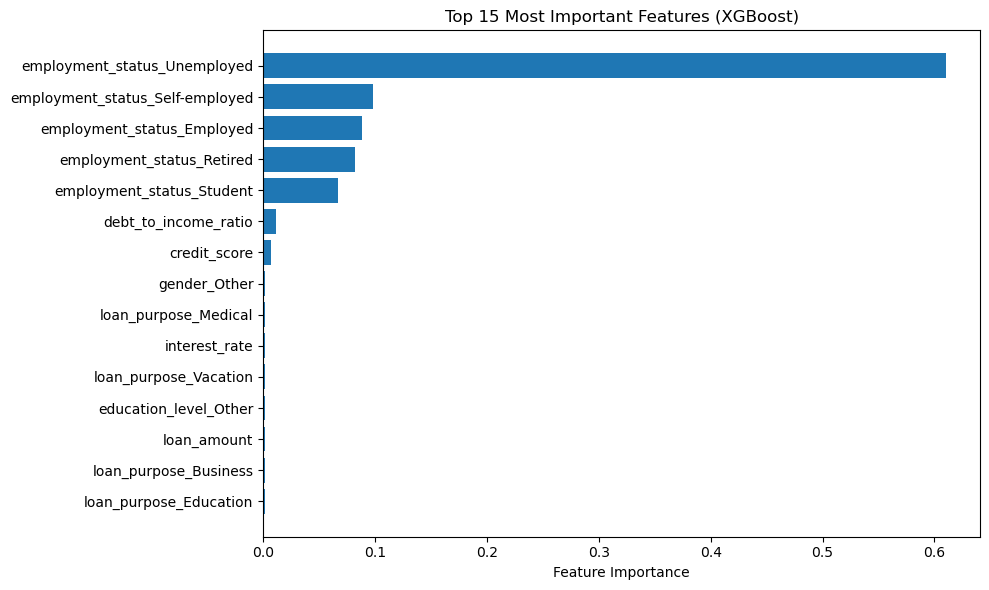


Step 3 complete: Model trained, tuned, and AUC maximized.
Final Test AUC: 0.9169


In [42]:

full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False))
])
param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 7, 9],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.7, 0.85, 1.0],
    'classifier__colsample_bytree': [0.7, 0.85, 1.0]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print('Starting RandomizedSearchCV for hyperparameter tuning...')
random_search = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

print('\nBest hyperparameters found:')
print(random_search.best_params_)
print('Best cross-validation AUC:', random_search.best_score_)
best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC on test set
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f'\nROC AUC on test set: {test_auc:.4f}')

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Feature importance from XGBoost
print('\nTop 15 most important features:')
feature_importance = best_model.named_steps['classifier'].feature_importances_
sorted_idx = np.argsort(feature_importance)[-15:]
top_features = [feature_names[i] for i in sorted_idx]
top_importance = feature_importance[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_importance)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features (XGBoost)')
plt.tight_layout()
plt.show()

# Create test set predictions DataFrame for later use
test_predictions_df = pd.DataFrame({
    'y_true': y_test.values,
    'y_pred_proba': y_pred_proba,
    'y_pred': (y_pred_proba >= 0.5).astype(int)
})

# Merge with original features for subgroup analysis
X_test_with_pred = X_test.copy()
X_test_with_pred['y_true'] = y_test.values
X_test_with_pred['y_pred_proba'] = y_pred_proba
X_test_with_pred['y_pred'] = (y_pred_proba >= 0.5).astype(int)

print('\nStep 3 complete: Model trained, tuned, and AUC maximized.')
print(f'Final Test AUC: {test_auc:.4f}')


--- AUC by Education Level ---


,group,n_samples,auc,default_rate
3,PhD,1870,0.925368,0.828877
4,Other,4434,0.918860,0.804240
1,High School,30617,0.917962,0.809420
0,Bachelor's,46715,0.916770,0.787370
2,Master's,15567,0.912863,0.804651



Overall AUC across all subgroups: 0.9169
AUC range (min-max): 0.9129 - 0.9254

--- AUC by Loan Purpose (All Groups) ---


,group,n_samples,auc,default_rate
7,Medical,3889,0.923371,0.776549
5,Education,6151,0.919750,0.777597
1,Business,5802,0.919729,0.817994
0,Debt consolidation,54336,0.916811,0.795844
4,Other,10563,0.916614,0.799015
2,Vacation,1411,0.916594,0.802268
3,Home,7351,0.914915,0.825874
6,Car,9700,0.912253,0.801134



*** Top 3 performing loan_purpose (by AUC) ***


,group,n_samples,auc,default_rate
7,Medical,3889,0.923371,0.776549
5,Education,6151,0.919750,0.777597
1,Business,5802,0.919729,0.817994



*** Bottom 3 performing loan_purpose (by AUC) ***


,group,n_samples,auc,default_rate
2,Vacation,1411,0.916594,0.802268
3,Home,7351,0.914915,0.825874
6,Car,9700,0.912253,0.801134



Overall AUC across all subgroups: 0.9169
AUC range (min-max): 0.9123 - 0.9234
AUC std dev: 0.0034


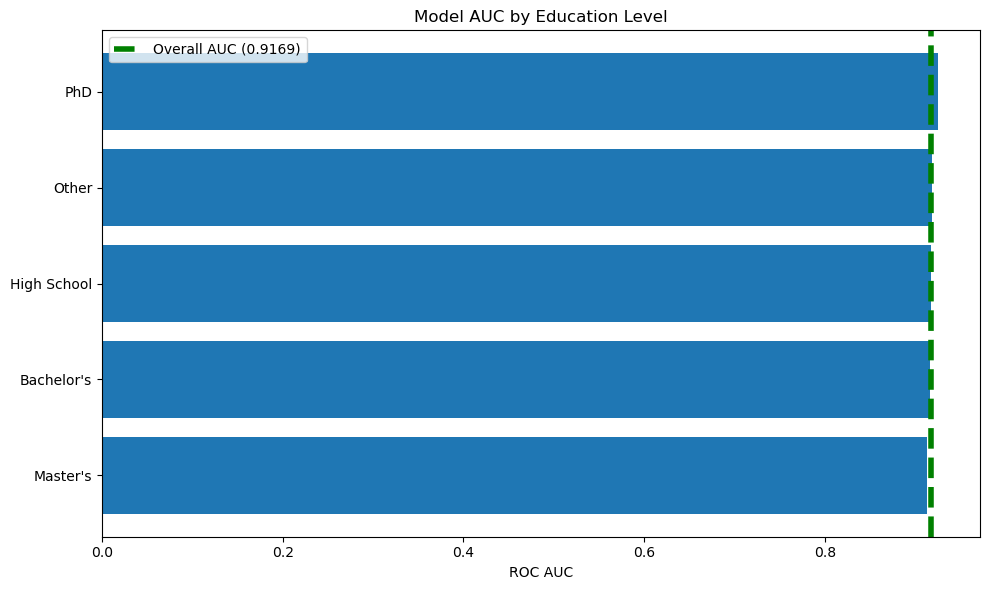

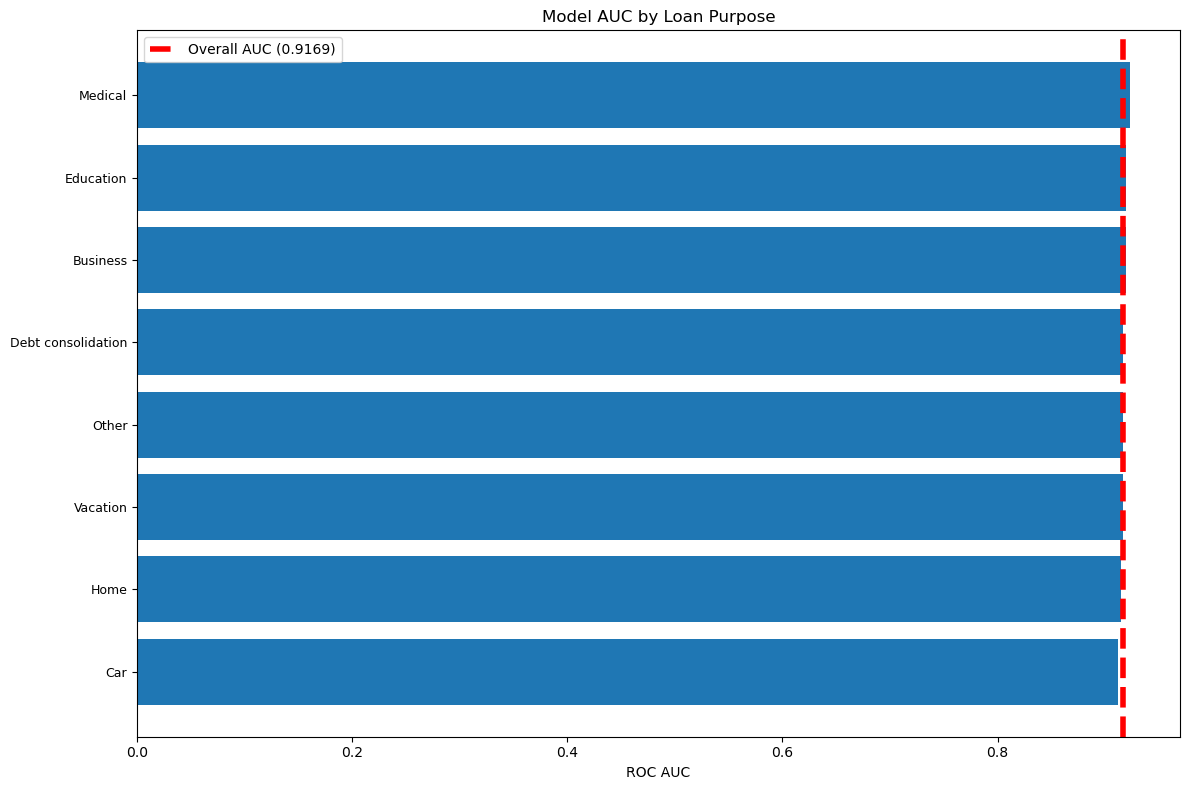

In [45]:
# Step 4: Subgroup Analysis
# Ensure fairness: compute AUC across education_level and loan_purpose subgroups


def compute_subgroup_auc(df, group_col, y_true_col='y_true', y_pred_col='y_pred_proba'):
    """Compute AUC for each subgroup"""
    results = []
    groups = df[group_col].fillna('MISSING').unique()

    for group in groups:
        mask = df[group_col].fillna('MISSING') == group
        y_true_sub = df.loc[mask, y_true_col]
        y_pred_sub = df.loc[mask, y_pred_col]

        # Need at least 2 samples and both classes present
        if len(y_true_sub) < 2 or len(np.unique(y_true_sub)) < 2:
            auc_score = np.nan
        else:
            auc_score = roc_auc_score(y_true_sub, y_pred_sub)

        results.append({
            'group': group,
            'n_samples': len(y_true_sub),
            'auc': auc_score,
            'default_rate': y_true_sub.mean()
        })

    return pd.DataFrame(results).sort_values('auc', ascending=False, na_position='last')

# Subgroup analysis by education_level
print("\n--- AUC by Education Level ---")
if 'education_level' in X_test_with_pred.columns:
    edu_auc = compute_subgroup_auc(X_test_with_pred, 'education_level')
    display(edu_auc)
    print(f"\nOverall AUC across all subgroups: {test_auc:.4f}")
    print(f"AUC range (min-max): {edu_auc['auc'].min():.4f} - {edu_auc['auc'].max():.4f}")
else:
    print("education_level not found in test set")

# Subgroup analysis by loan_purpose - top 3 and bottom 3
print("\n--- AUC by Loan Purpose (All Groups) ---")
if 'loan_purpose' in X_test_with_pred.columns:
    purpose_auc = compute_subgroup_auc(X_test_with_pred, 'loan_purpose')
    display(purpose_auc)

    print("\n*** Top 3 performing loan_purpose (by AUC) ***")
    top_3 = purpose_auc.dropna(subset=['auc']).head(3)
    display(top_3)

    print("\n*** Bottom 3 performing loan_purpose (by AUC) ***")
    bottom_3 = purpose_auc.dropna(subset=['auc']).tail(3)
    display(bottom_3)

    print(f"\nOverall AUC across all subgroups: {test_auc:.4f}")
    print(f"AUC range (min-max): {purpose_auc['auc'].min():.4f} - {purpose_auc['auc'].max():.4f}")
    print(f"AUC std dev: {purpose_auc['auc'].std():.4f}")
else:
    print("loan_purpose not found in test set")

# Visualization: AUC by education_level
if 'education_level' in X_test_with_pred.columns:
    plt.figure(figsize=(10, 6))
    edu_auc_sorted = edu_auc.dropna(subset=['auc']).sort_values('auc')
    plt.barh(range(len(edu_auc_sorted)), edu_auc_sorted['auc'])
    plt.yticks(range(len(edu_auc_sorted)), edu_auc_sorted['group'])
    plt.xlabel('ROC AUC')
    plt.title('Model AUC by Education Level')
    plt.axvline(test_auc, color='green', linestyle='--', linewidth=4, label=f'Overall AUC ({test_auc:.4f})')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Visualization: AUC by loan_purpose (all groups)
if 'loan_purpose' in X_test_with_pred.columns:
    plt.figure(figsize=(12, 8))
    purpose_auc_sorted = purpose_auc.dropna(subset=['auc']).sort_values('auc')
    plt.barh(range(len(purpose_auc_sorted)), purpose_auc_sorted['auc'])
    plt.yticks(range(len(purpose_auc_sorted)), purpose_auc_sorted['group'], fontsize=9)
    plt.xlabel('ROC AUC')
    plt.title('Model AUC by Loan Purpose')
    plt.axvline(test_auc, color='red', linestyle='--', linewidth=4, label=f'Overall AUC ({test_auc:.4f})')
    plt.legend()
    plt.tight_layout()
    plt.show()
